In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from common.preprocessor import load_data, mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('Prophet data.csv',parse_dates=True, index_col=[0])

In [3]:
data.head()

,Price
2018-01-01,69.09
2018-02-01,65.70
2018-03-01,66.68
2018-04-01,71.67
2018-05-01,77.06


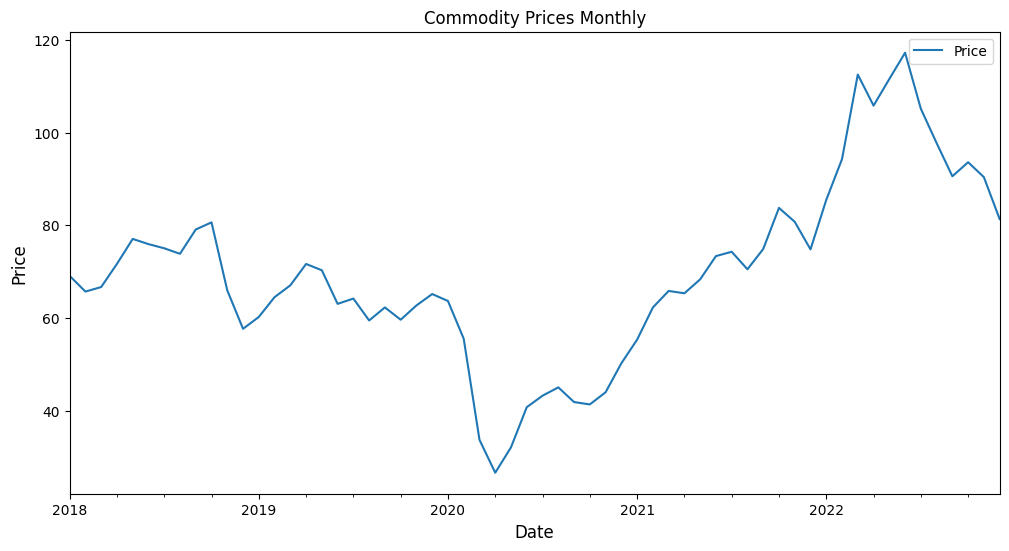

In [4]:
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [5]:
#create training and testing datasets
train, test = train_test_split(data, test_size=0.05, shuffle=False)

In [6]:
train.shape, test.shape

((57, 1), (3, 1))

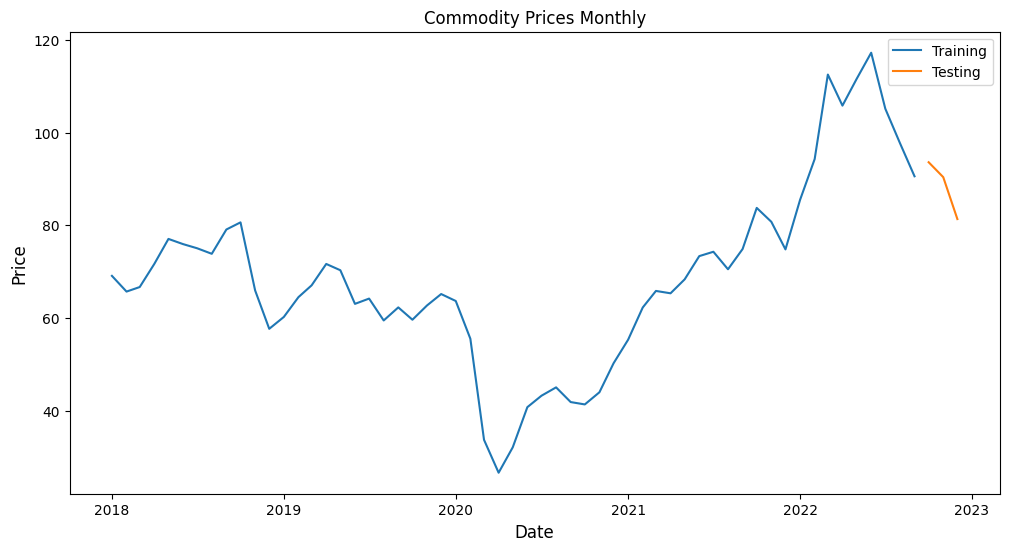

In [7]:
# visualize the training and testing datasets
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.title('Commodity Prices Monthly')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.show()

In [9]:
# prepare data for training
scaler = MinMaxScaler()
train['Price'] = scaler.fit_transform(train[['Price']])
train.head()

,Price
2018-01-01,0.47
2018-02-01,0.43
2018-03-01,0.44
2018-04-01,0.50
2018-05-01,0.56


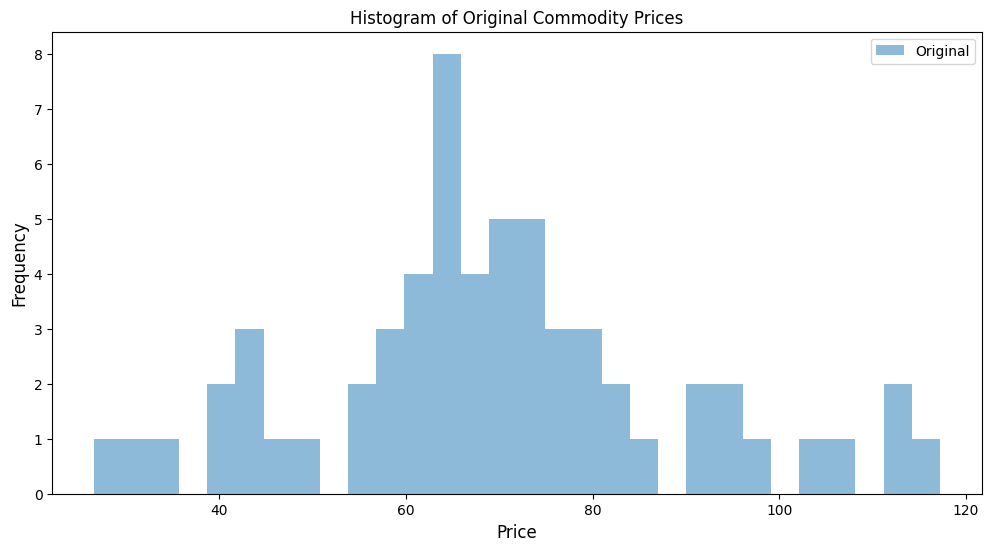

In [10]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.hist(data['Price'], bins=30, alpha=0.5, label='Original')
plt.title('Histogram of Original Commodity Prices')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

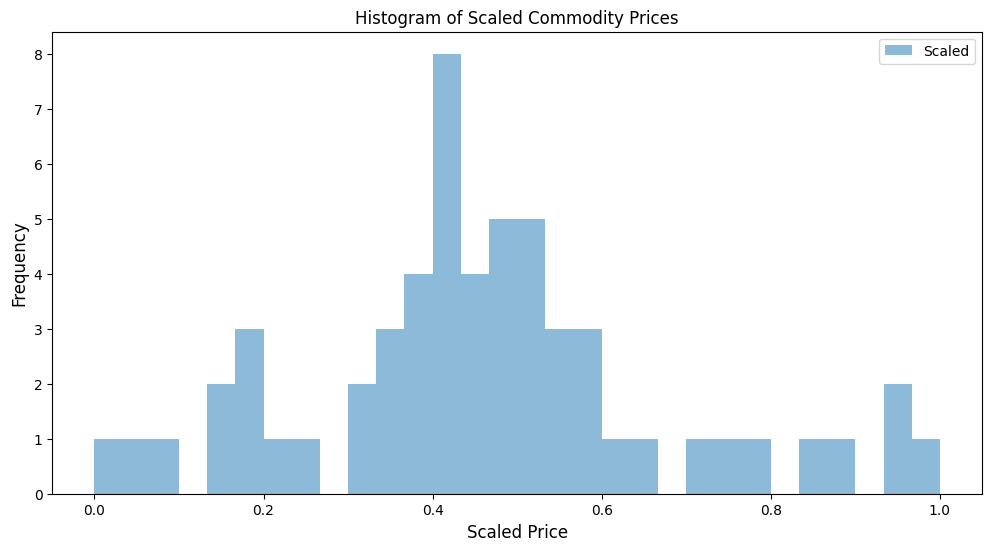

In [11]:
# Plot scaled data
plt.figure(figsize=(12, 6))
plt.hist(train['Price'], bins=30, alpha=0.5, label='Scaled')
plt.title('Histogram of Scaled Commodity Prices')
plt.xlabel('Scaled Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

In [12]:
# scale test data
test['Price'] = scaler.fit_transform(test[['Price']])
test.head()

,Price
2022-10-01,1.00
2022-11-01,0.74
2022-12-01,0.00


In [13]:
import pmdarima as pm

# Assuming `data` is your time series data
n_diffs = pm.arima.ndiffs(data, test='adf')  # 'adf' for Augmented Dickey-Fuller test

print(f"Number of differences required: {n_diffs}")

Number of differences required: 2


In [47]:
# use auto arima to find the best parameters
model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-79.477, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-72.795, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-78.681, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-81.231, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-77.603, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-78.907, Time=0.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-77.860, Time=0.18 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-79.863, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-81.074, Time=0.24 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-78.002, Time=1.05 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-79.568, Time=0.62 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]        

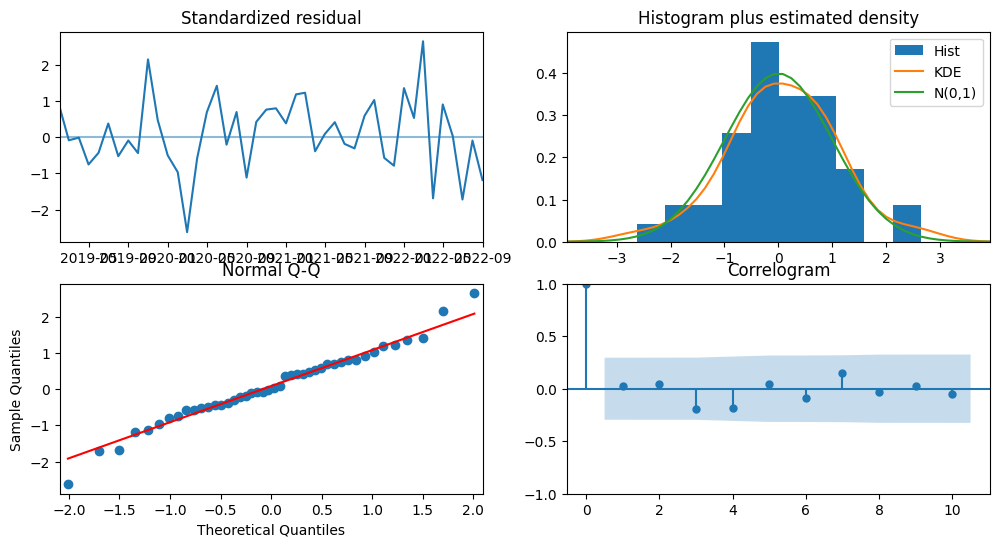

In [48]:
plot = model.plot_diagnostics(figsize=(12, 6))

In [51]:
HORIZON = 1
print(f'Forecasting {HORIZON} months')

Forecasting 1 months


In [52]:
# create test data point for each horizon step
test_shifted = test.copy()
for t in range(1, HORIZON+1):
    test_shifted[f'Price+{t}'] = test_shifted['Price'].shift(-t, freq='MS')
test_shifted = test_shifted.dropna(how='any') # remove rows with NaNs
test_shifted.head()

,Price,Price+1
2022-10-01,1.00,0.74
2022-11-01,0.74,0.00


In [53]:
%%time
from statsmodels.tsa.statespace.sarimax import SARIMAX

# train the model
train_window = len(train)

train_ts = train['Price']
test_ts = test_shifted['Price']

history = [x for x in train_ts]
history = history[-train_window:]
predictions = list()

order = (1,1,0)
seasonal_order = (1,1,0,12)

for t in range(len(test_ts)):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = test_ts.iloc[t]
    history.append(obs) # move the training window
    history.pop(0)
    print(f'Month={t+1}, predicted={yhat}, expected={obs}')


Month=1, predicted=[0.74], expected=1.0
Month=2, predicted=[1.05], expected=0.7373572593800972
CPU times: total: 15.6 ms
Wall time: 506 ms
